## **Creating the synthetic dataset**

In [ ]:
pip install pandas numpy scikit-learn faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Dataset size
num_records = 70000


symptoms = [
    "chest_pain", "shortness_of_breath", "irregular_heartbeat", "fatigue_weakness",
    "dizziness", "swelling_edema", "neck_jaw_pain", "excessive_sweating",
    "persistent_cough", "nausea_vomiting", "high_blood_pressure", "chest_discomfort",
    "cold_hands_feet", "snoring_sleep_apnea", "anxiety_doom"
]

demographics = ["age", "gender"]

# Target variables
targets = ["at_risk", "stroke_risk_percentage"]

In [24]:
fake = Faker()

# Generate age and gender
def generate_demographics():
    age = np.random.randint(18, 90)  # Age range
    gender = np.random.choice(["Male", "Female"])  # Gender
    return age, gender

In [25]:
def generate_symptoms():
    symptom_data = {}
    for symptom in symptoms:
        # Assign a probability of the symptom being present (e.g., 30% for chest pain)
        prob = np.random.choice([0, 1], p=[0.7, 0.3])  # Adjust probabilities as needed
        symptom_data[symptom] = prob
    return symptom_data

In [26]:
def generate_targets(symptom_data, age):
    # Calculate a risk score based on symptoms and age
    risk_score = sum(symptom_data.values()) * 5 + (age / 10)  # Example formula
    risk_score = np.clip(risk_score, 0, 100)  # Clip to 0-100 range

    # Binary at_risk based on a threshold (e.g., 50%)
    at_risk = 1 if risk_score > 50 else 0

    return at_risk, risk_score

In [27]:
# Initialize an empty list to store records
data = []

# Generate records
for _ in range(num_records):
    age, gender = generate_demographics()
    symptom_data = generate_symptoms()
    at_risk, stroke_risk = generate_targets(symptom_data, age)

    # Combine all data into a single record
    record = {
        "age": age,
        "gender": gender,
        **symptom_data,  # Unpack symptom data
        "at_risk": at_risk,
        "stroke_risk_percentage": stroke_risk
    }
    data.append(record)

# Convert to DataFrame
df = pd.DataFrame(data)

In [ ]:
# Split the dataset into at-risk and not-at-risk
at_risk_df = df[df["at_risk"] == 1]
not_at_risk_df = df[df["at_risk"] == 0]

# Balance the dataset
min_samples = min(len(at_risk_df), len(not_at_risk_df))
balanced_df = pd.concat([
    at_risk_df.sample(min_samples),
    not_at_risk_df.sample(min_samples)
])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [ ]:
balanced_df.to_csv("stroke_risk_dataset.csv", index=False)

In [ ]:
print(balanced_df.head())
print(balanced_df["at_risk"].value_counts())
print(balanced_df.describe())

   age  gender  chest_pain  shortness_of_breath  irregular_heartbeat  \
0   56  Female           0                    0                    0   
1   79  Female           0                    0                    1   
2   35  Female           1                    0                    0   
3   26    Male           0                    0                    1   
4   48    Male           1                    0                    0   

   fatigue_weakness  dizziness  swelling_edema  neck_jaw_pain  \
0                 0          1               0              0   
1                 0          1               0              1   
2                 0          0               0              0   
3                 0          1               0              0   
4                 1          0               0              0   

   excessive_sweating  persistent_cough  nausea_vomiting  high_blood_pressure  \
0                   0                 0                0                    0   
1             

For more rigorousity, we have to keep one thing in our mind that, age is a critical non-linear predictor of stroke risk. Let’s refine the synthetic dataset generation to reflect this relationship accurately.

In [28]:
import pandas as pd
import numpy as np
from faker import Faker

# Initialize
fake = Faker()
np.random.seed(42)

# Parameters
num_records = 35_000
age_bins = [18, 30, 50, 70, 90]

# Symptoms (as before)
symptoms = [
    "chest_pain", "shortness_of_breath", "irregular_heartbeat", "fatigue_weakness",
    "dizziness", "swelling_edema", "neck_jaw_pain", "excessive_sweating",
    "persistent_cough", "nausea_vomiting", "high_blood_pressure", "chest_discomfort",
    "cold_hands_feet", "snoring_sleep_apnea", "anxiety_doom"
]

In [29]:
symptom_probs = {
    # Format: {symptom: [prob_18-30, prob_31-50, prob_51-70, prob_71-90]}
    "chest_pain": [0.05, 0.15, 0.25, 0.35],  # Rare in young, common in elderly
    "high_blood_pressure": [0.10, 0.25, 0.45, 0.60],  # Major risk factor, increases with age
    "irregular_heartbeat": [0.02, 0.10, 0.20, 0.30],  # Arrhythmias more common in older adults
    "shortness_of_breath": [0.10, 0.20, 0.30, 0.40],  # Linked to heart and lung conditions
    "fatigue_weakness": [0.15, 0.25, 0.35, 0.45],  # General symptom, increases with age
    "dizziness": [0.10, 0.20, 0.30, 0.40],  # Often related to blood pressure or neurological issues
    "swelling_edema": [0.05, 0.15, 0.25, 0.35],  # Fluid retention, more common in elderly
    "neck_jaw_pain": [0.02, 0.10, 0.20, 0.30],  # Often related to cardiovascular issues
    "excessive_sweating": [0.05, 0.10, 0.15, 0.20],  # Less common, but increases with age
    "persistent_cough": [0.05, 0.10, 0.20, 0.30],  # Linked to heart failure in older adults
    "nausea_vomiting": [0.05, 0.10, 0.15, 0.20],  # Less common, but increases with age
    "chest_discomfort": [0.05, 0.15, 0.25, 0.35],  # Similar to chest pain
    "cold_hands_feet": [0.10, 0.20, 0.30, 0.40],  # Linked to poor circulation, more common in elderly
    "snoring_sleep_apnea": [0.05, 0.15, 0.25, 0.35],  # Increases with age and weight
    "anxiety_doom": [0.05, 0.10, 0.15, 0.20]  # Psychological symptoms, slightly increases with age
}

In [30]:
def generate_age():
    # More records for older ages (beta distribution)
    age = np.round(18 + (90-18) * np.random.beta(2, 5))
    return int(np.clip(age, 18, 90))

In [31]:
def sigmoid_risk(age):
    """S-shaped curve for base age risk (sharp increase after 50)."""
    return 1 / (1 + np.exp(-0.1*(age-60)))  # Medical cutoff around 60

def gender_risk_modifier(age, gender):
    """Higher risk for males <60, females >60 (post-menopausal)."""
    if gender == "Male":
        return 1.5 if age < 60 else 1.2
    else:
        return 1.0 if age < 60 else 1.8


In [32]:
def generate_symptoms(age):
    symptoms_present = {}
    age_group = np.digitize(age, age_bins) - 1  # Convert age to bin index

    for symptom, probs in symptom_probs.items():
        prob = probs[age_group]
        symptoms_present[symptom] = np.random.choice([0, 1], p=[1-prob, prob])

    return symptoms_present

In [34]:
data = []
for _ in range(num_records):
    age = generate_age()
    gender = np.random.choice(["Male", "Female"])
    symptoms = generate_symptoms(age)
    risk_pct = calculate_stroke_risk(age, gender, symptoms)
    at_risk = 1 if risk_pct >= 50 else 0  # Threshold for binary classification

    data.append({
        "age": age,
        "gender": gender,
        **symptoms,
        "stroke_risk_percentage": np.round(risk_pct, 1),
        "at_risk": at_risk
    })

df = pd.DataFrame(data)

In [35]:
from sklearn.model_selection import train_test_split
_, df_balanced = train_test_split(
    df,
    test_size=0.5,
    stratify=df["at_risk"],
    random_state=42
)

# Shuffle
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [36]:
df_balanced.to_csv("stroke_risk_dataset_v2.csv", index=False)

In [37]:
# Checking the age distribution in risk groups
print("Age Distribution by Risk Group:")
print(df_balanced.groupby("at_risk")["age"].describe())

# Verifying symptom prevalence increases with age
for symptom in ["high_blood_pressure", "chest_pain"]:
    print(f"\n{symptom} Prevalence by Age Group:")
    df_balanced["age_group"] = pd.cut(df_balanced["age"], bins=age_bins)
    print(df_balanced.groupby("age_group")[symptom].mean())

Age Distribution by Risk Group:
           count       mean        std   min   25%   50%   75%   max
at_risk                                                             
0        22113.0  32.763804   7.616959  18.0  27.0  32.0  38.0  59.0
1        12887.0  48.696361  10.161924  19.0  41.0  49.0  55.0  86.0

high_blood_pressure Prevalence by Age Group:
age_group
(18, 30]    0.116943
(30, 50]    0.257626
(50, 70]    0.458621
(70, 90]    0.575630
Name: high_blood_pressure, dtype: float64

chest_pain Prevalence by Age Group:
age_group
(18, 30]    0.063741
(30, 50]    0.155872
(50, 70]    0.249909
(70, 90]    0.302521
Name: chest_pain, dtype: float64


<ipython-input-37-962b88117db3>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_balanced.groupby("age_group")[symptom].mean())


# **Age Distribution Plot**

<ipython-input-43-146ea3849826>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset Version", fontsize=12)


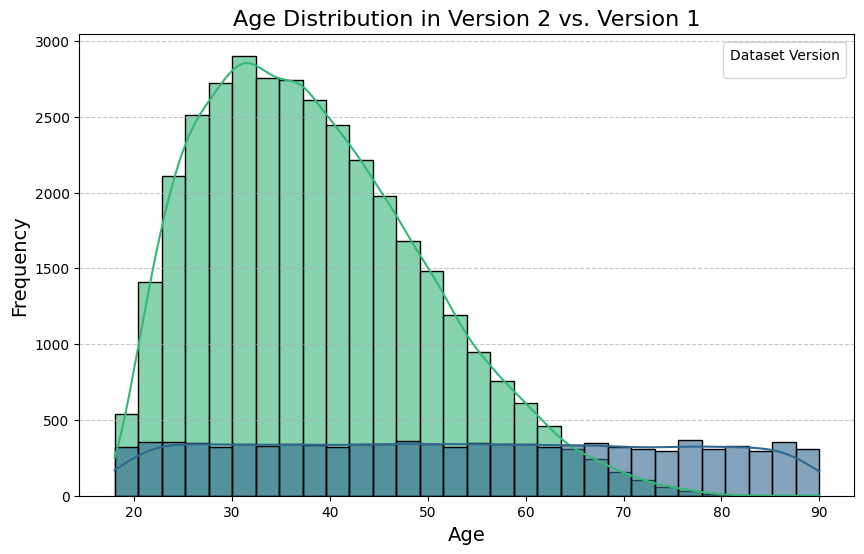

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Generate synthetic age data for Version 1 and Version 2
np.random.seed(42)

# Version 1: Linear age distribution (uniform)
age_v1 = np.random.uniform(18, 90, size=10000)

# Version 2: Skewed age distribution (beta distribution to simulate older population)
age_v2 = 18 + (90 - 18) * np.random.beta(2, 5, size=35000)

# Create a DataFrame for plotting
df_v1 = pd.DataFrame({"Age": age_v1, "Version": "Version 1"})
df_v2 = pd.DataFrame({"Age": age_v2, "Version": "Version 2"})
df = pd.concat([df_v1, df_v2])

# Plot age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Age", hue="Version", kde=True, bins=30, palette="viridis", alpha=0.6)
plt.title("Age Distribution in Version 2 vs. Version 1", fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Dataset Version", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the plot as a PNG file
plt.savefig("age_dist_plot.png", dpi=300, bbox_inches="tight")
plt.show()

Visit the dataset and notebooks from [here](https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data)